In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
data = pd.read_csv('real_estate.csv')
data

In [ ]:
data.head()

In [ ]:
print(data.columns)

In [ ]:

# Convert date to datetime
data['date_of_transfer'] = pd.to_datetime(data['date_of_transfer'])

data = data[(data['date_of_transfer'] >= '2025-04-01') & (data['date_of_transfer'] <= '2025-12-31')]

# data.to_csv('real_estate.csv', index=False)

data

In [6]:
# Fill NaN with 'missing'
data.fillna('missing', inplace=True)

# Create property identifier before dropping transaction_id (to enable lag features)
data['property_id'] = data['paon'].astype(str) + '_' + data['street'].astype(str) + '_' + data['postcode'].astype(str)

# Drop unique identifier if exists
if 'transaction_id' in data.columns:
    data.drop('transaction_id', axis=1, inplace=True)

le_dict = {}

# Label encode categorical columns
categorical_cols = data.select_dtypes(include=['object']).columns
for col in categorical_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])

# Extract date features
data['year'] = data['date_of_transfer'].dt.year
data['month'] = data['date_of_transfer'].dt.month
data['day'] = data['date_of_transfer'].dt.day
# data.drop('date_of_transfer', axis=1, inplace=True)

# Feature Engineering for better correlations

# Parse postcode
def parse_postcode(pc):
    if pc == 'missing':
        return {'postcode_area': 0, 'postcode_district': 0, 'postcode_sector': 0}
    try:
        parts = str(pc).split()
        if len(parts) != 2:
            return {'postcode_area': 0, 'postcode_district': 0, 'postcode_sector': 0}
        outward, inward = parts
        i = 0
        while i < len(outward) and outward[i].isalpha():
            i += 1
        area = outward[:i]
        district_str = outward[i:]
        district = int(district_str) if district_str.isdigit() else 0
        sector = int(inward[0]) if inward[0].isdigit() else 0
        area_code = ord(area[0]) if area else 0  # Simple encoding for area
        return {'postcode_area': area_code, 'postcode_district': district, 'postcode_sector': sector}
    except:
        return {'postcode_area': 0, 'postcode_district': 0, 'postcode_sector': 0}

postcode_df = data['postcode'].apply(parse_postcode).apply(pd.Series)
data = pd.concat([data, postcode_df], axis=1)

# Target encoding for location and other categorical features to improve correlation with price
target_cols = ['postcode', 'postcode_area', 'postcode_district', 'postcode_sector', 'street', 'locality', 'town_city', 'district', 'county', 'property_type', 'old_new', 'duration']
for col in target_cols:
    if col in data.columns:
        mean_price = data.groupby(col)['price'].mean()
        data[col + '_mean_price'] = data[col].map(mean_price)

# Additional time features
data['quarter'] = (data['month'] - 1) // 3 + 1
data['day_of_year'] = data['month'] * 30 + data['day']  # Approximate
data['is_new'] = (data['old_new'] == le_dict['old_new'].transform(['Y'])[0]).astype(int) if 'old_new' in le_dict else 0

# Interaction features
data['type_duration_inter'] = data['property_type'] * data['duration']
data['location_type_inter'] = data['district'] * data['property_type']

In [7]:
# Create lag features for properties with multiple transactions
# Sort by property_id and date to ensure proper ordering
data = data.sort_values(['property_id', 'year', 'month', 'day'])

# Create lag features for key metrics
lag_periods = [1, 2, 3]  # Previous 1, 2, and 3 transactions
lag_features = ['price', 'property_type', 'old_new', 'duration']

for feature in lag_features:
    for lag in lag_periods:
        data[f'{feature}_lag_{lag}'] = data.groupby('property_id')[feature].shift(lag)

# Create time difference features (days since last transaction)
data['days_since_last_transaction'] = data.groupby('property_id')['day_of_year'].diff()

# Fill NaN values in lag features (properties with no previous transactions)
lag_cols = [col for col in data.columns if '_lag_' in col or 'days_since' in col]
for col in lag_cols:
    data[col].fillna(0, inplace=True)

# Check how many properties have lag features
properties_with_history = (data.groupby('property_id').size() > 1).sum()
print(f"Properties with multiple transactions: {properties_with_history}")
print(f"New lag features created: {len(lag_cols)}")
print(f"Total features now: {len(data.columns)}")

# Show sample of lag features
print("\nSample of data with lag features:")
sample_property = data[data.groupby('property_id')['property_id'].transform('size') > 1]['property_id'].iloc[0]
data[data['property_id'] == sample_property][['property_id', 'price', 'price_lag_1', 'price_lag_2', 'days_since_last_transaction']].head()

Properties with multiple transactions: 7130
New lag features created: 13
Total features now: 52

Sample of data with lag features:


,property_id,price,price_lag_1,price_lag_2,days_since_last_transaction
69124,12,120000,0.0,0.0,0.0
562445,12,120000,120000.0,0.0,34.0


In [8]:
data

,price,date_of_transfer,postcode,property_type,old_new,duration,paon,saon,street,locality,...,property_type_lag_1,property_type_lag_2,property_type_lag_3,old_new_lag_1,old_new_lag_2,old_new_lag_3,duration_lag_1,duration_lag_2,duration_lag_3,days_since_last_transaction
175813,55000,2025-10-08,169055,1,0,1,0,2925,117631,12577,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
378394,1500000,2025-08-08,110284,2,0,0,1,2925,18251,3879,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
166821,350000,2025-06-25,178026,2,0,0,2,2925,54196,10793,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
584447,305000,2025-10-30,30853,4,0,0,3,2925,51431,3402,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
74687,330000,2025-05-06,176371,2,0,0,4,2925,38464,820,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98111,690000,2025-08-12,98377,0,0,0,34925,2925,15490,12577,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
367331,420000,2025-04-11,273444,0,0,0,34926,2925,117736,11214,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
273268,690000,2025-11-21,191100,0,0,0,34927,2925,26513,8138,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
373228,1150000,2025-08-08,130134,0,0,0,34928,5,32899,1820,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
scaler = MinMaxScaler()

for

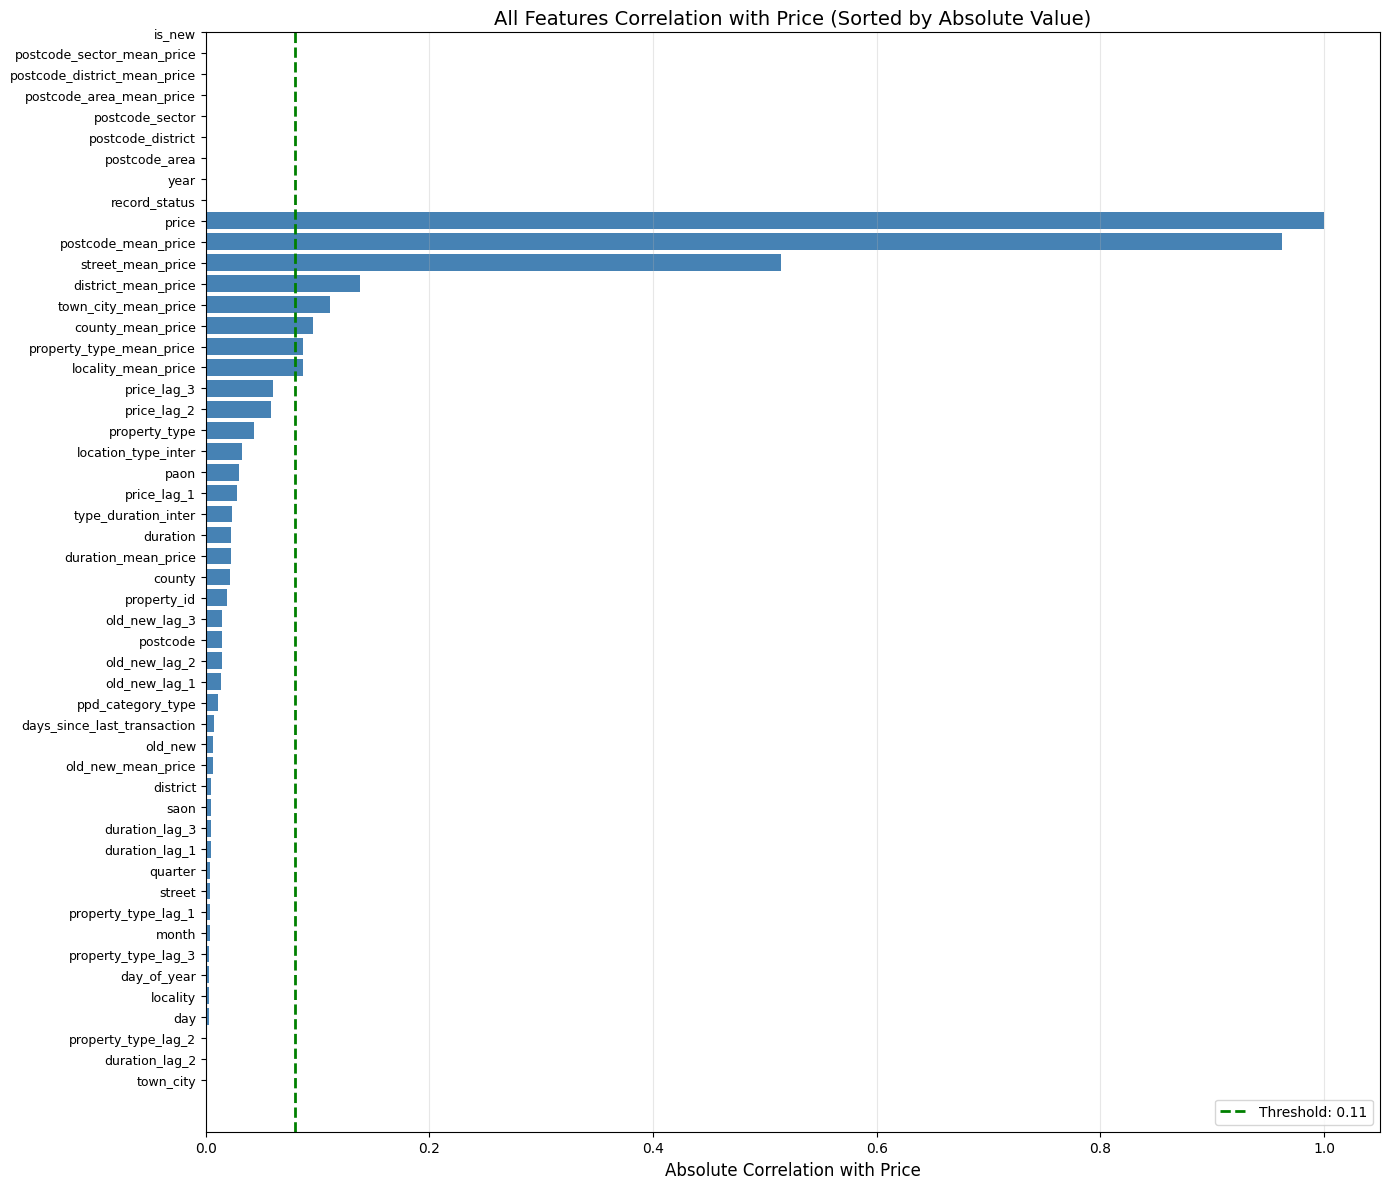


Total features plotted: 51
Features above 0.11 threshold: 5


In [9]:
# Calculate complete correlation matrix first
complete_correlation_matrix = data.corr(numeric_only=True)
complete_price_corr = complete_correlation_matrix['price'].abs()

# Plot all features correlation with price as a bar chart
plt.figure(figsize=(14, 12))
complete_price_corr_sorted = complete_price_corr.sort_values(ascending=True)

# Create horizontal bar chart
colors = ['red' if x < 0 else 'steelblue' for x in complete_price_corr_sorted.values]
plt.barh(range(len(complete_price_corr_sorted)), complete_price_corr_sorted.values, color=colors)
plt.yticks(range(len(complete_price_corr_sorted)), complete_price_corr_sorted.index, fontsize=9)
plt.xlabel('Absolute Correlation with Price', fontsize=12)
plt.title('All Features Correlation with Price (Sorted by Absolute Value)', fontsize=14)
plt.axvline(x=0.08, color='green', linestyle='--', linewidth=2, label='Threshold: 0.11')
plt.legend()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nTotal features plotted: {len(complete_price_corr_sorted)}")
print(f"Features above 0.11 threshold: {(complete_price_corr > 0.11).sum()}")

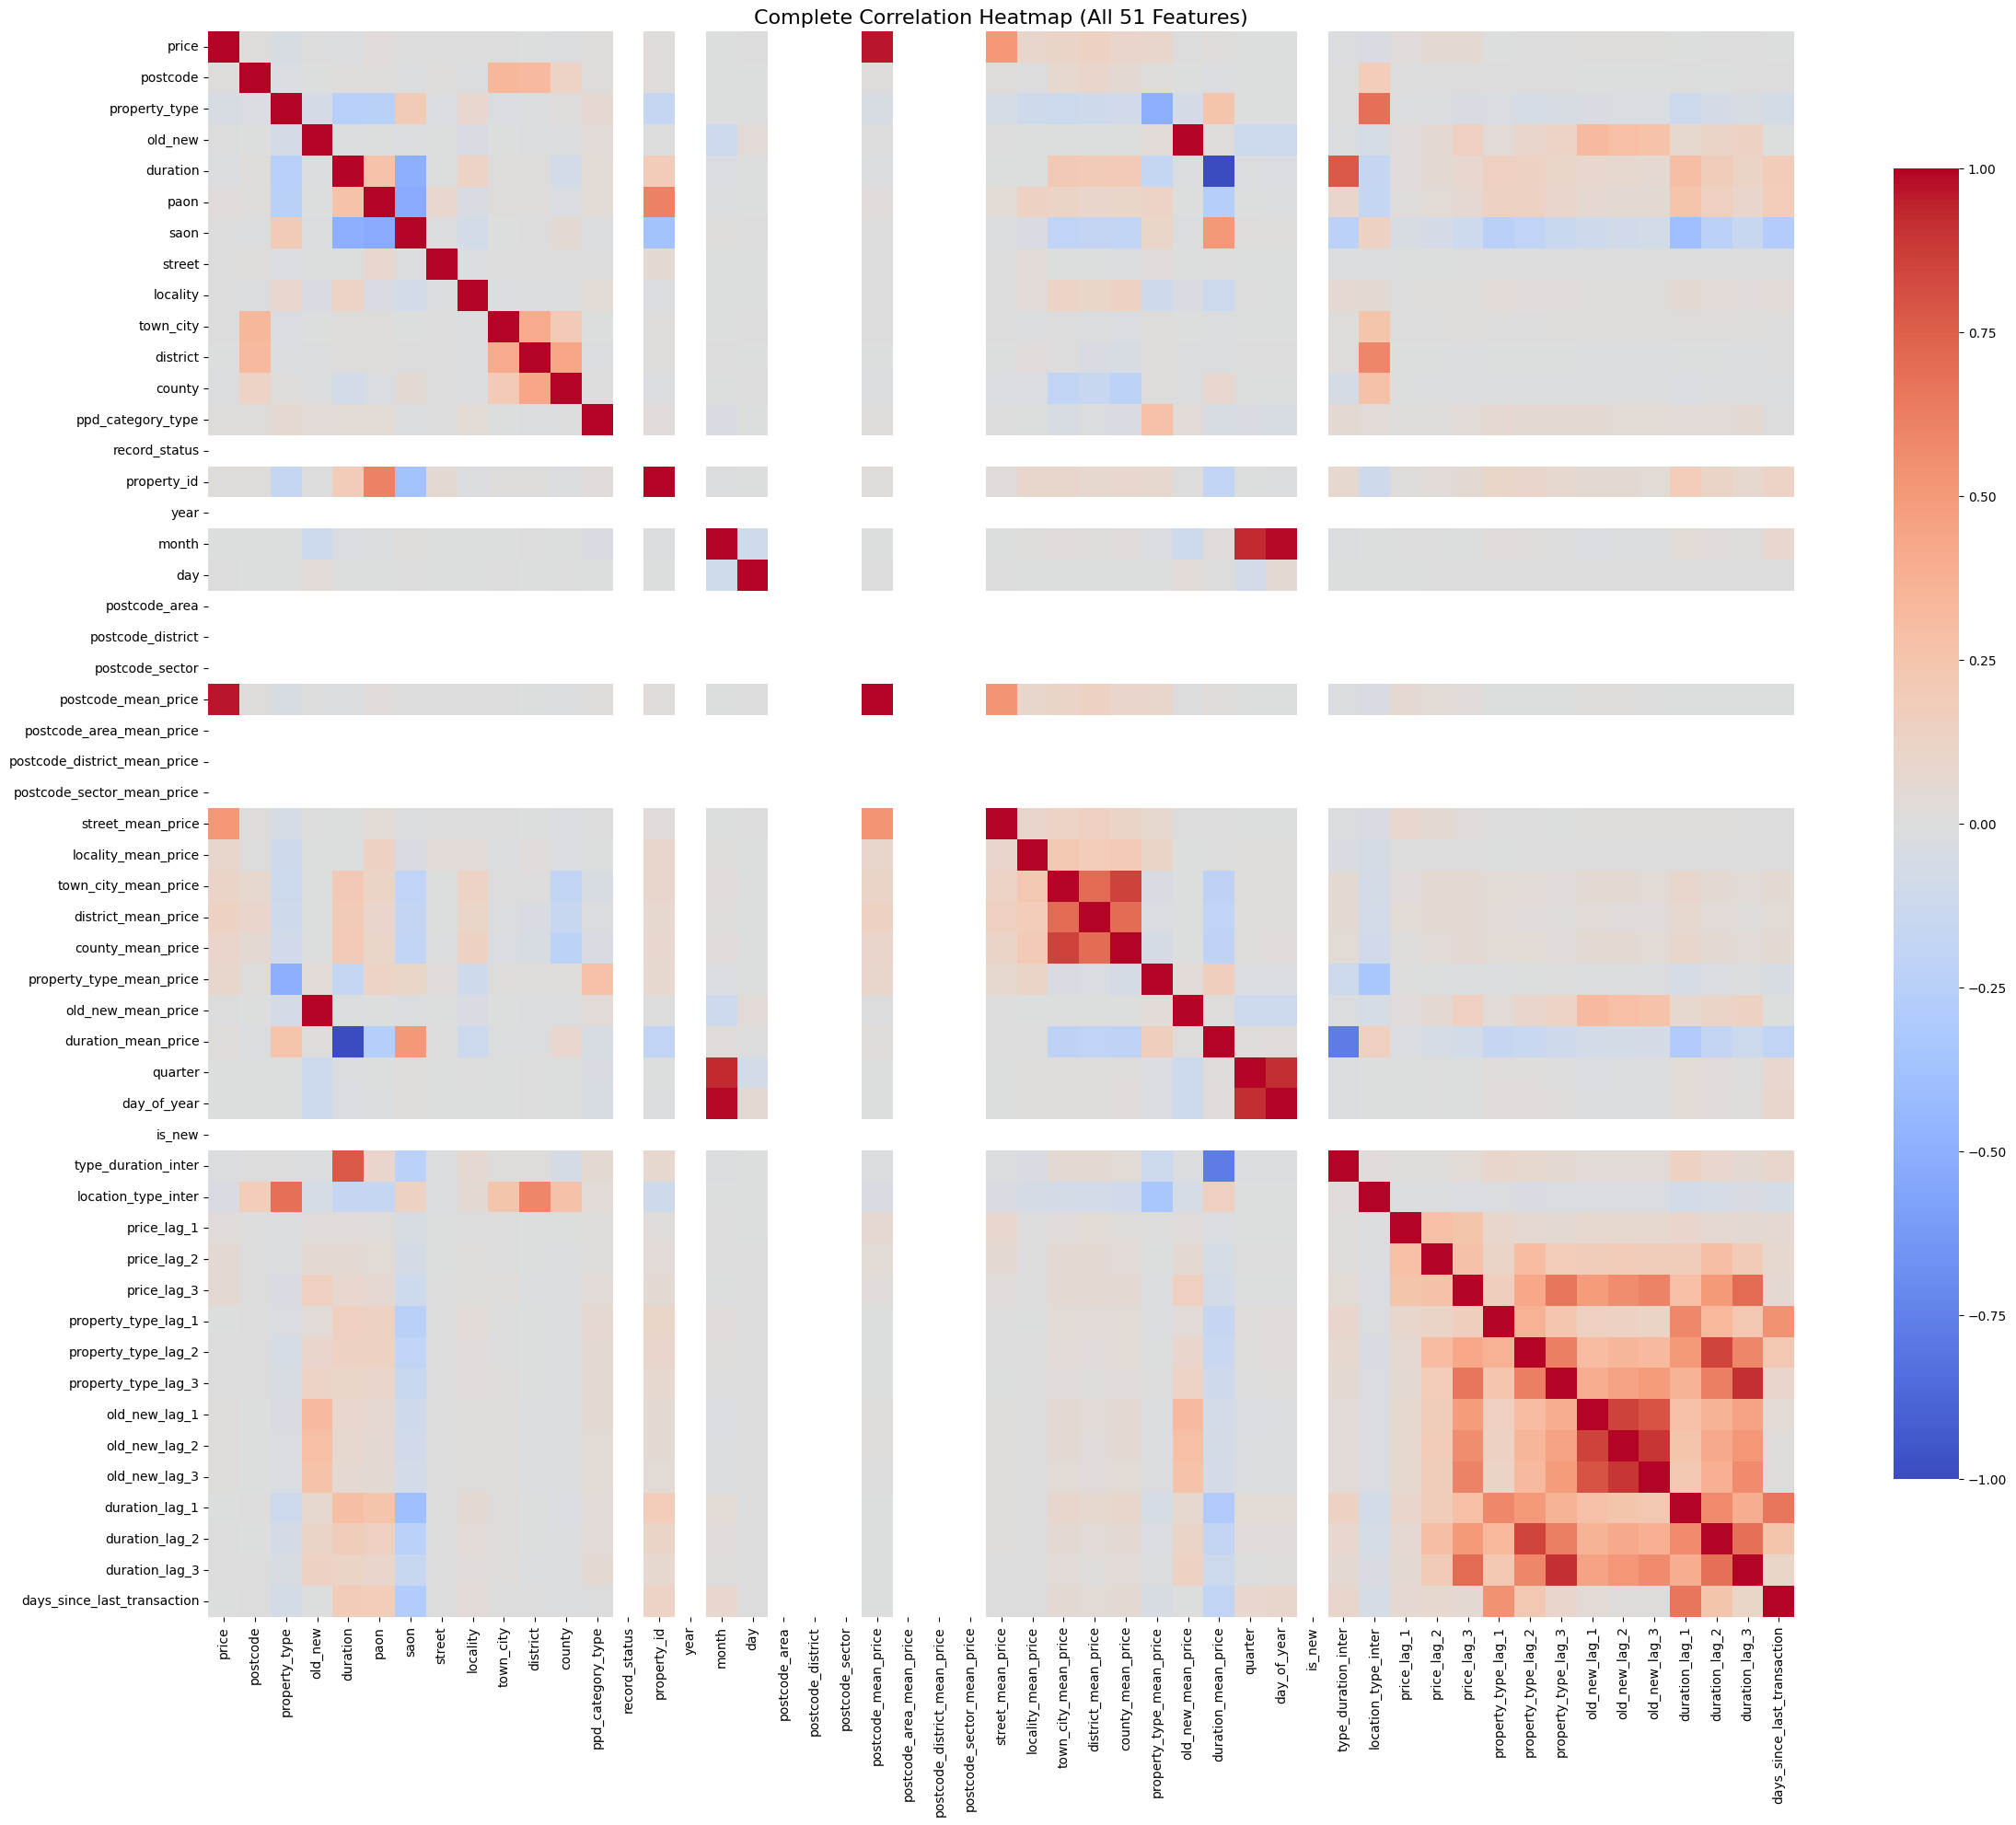

Total features in heatmap: 51


In [10]:
# Recalculate complete correlation matrix with all features
complete_correlation_matrix = data.corr(numeric_only=True)

# Plot complete correlation heatmap
plt.figure(figsize=(24, 20))
sns.heatmap(complete_correlation_matrix, annot=False, fmt='.2f', cmap='coolwarm', center=0, square=True, cbar_kws={'shrink': 0.8})
plt.title('Complete Correlation Heatmap (All 51 Features)', fontsize=16)
plt.tight_layout()
plt.show()

print(f"Total features in heatmap: {complete_correlation_matrix.shape[0]}")

In [13]:
# Get all features with correlation > 0.11 with price
complete_price_corr = complete_correlation_matrix['price'].abs()
all_high_corr_features = complete_price_corr[complete_price_corr > 0.8]

# Select only high correlation features from the data
high_corr_columns = list(all_high_corr_features.index)
high_corr_data = data[high_corr_columns + ['date_of_transfer']].copy()

# Save to CSV
high_corr_data.to_csv('preprocessed_real_estate_high_corr.csv', index=False)

print(f"Saved {len(high_corr_columns)} high correlation features to 'preprocessed_real_estate_high_corr.csv'")
print(f"\nFeatures saved: {high_corr_columns}")
print(f"\nDataset shape: {high_corr_data.shape}")
print(f"Total records: {len(high_corr_data)}")

Saved 2 high correlation features to 'preprocessed_real_estate_high_corr.csv'

Features saved: ['price', 'postcode_mean_price']

Dataset shape: (354089, 3)
Total records: 354089


In [14]:
high_corr_data


,price,postcode_mean_price,date_of_transfer
175813,55000,5.500000e+04,2025-10-08
378394,1500000,1.500000e+06,2025-08-08
166821,350000,3.500000e+05,2025-06-25
584447,305000,3.050000e+05,2025-10-30
74687,330000,3.300000e+05,2025-05-06
...,...,...,...
98111,690000,6.900000e+05,2025-08-12
367331,420000,6.801176e+05,2025-04-11
273268,690000,6.900000e+05,2025-11-21
373228,1150000,1.150000e+06,2025-08-08


In [15]:
data.to_csv('preprocessed_real_estate_full.csv', index=False)
print("Saved full preprocessed dataset to 'preprocessed_real_estate_full.csv'")

Saved full preprocessed dataset to 'preprocessed_real_estate_full.csv'
